# Description
<span style="color: red;">- max 2000 written words, not including citations

Title
    
Introduction:
    
<span style="color: red;">- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
    
<span style="color: red;">- clearly state the question you tried to answer with your project
    
<span style="color: red;">- identify and describe the dataset that was used to answer the question
    
Methods & Results:
    
<span style="color: red;">- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.

your report should include code which:
    
- (Done)loads data from the original source on the web 
    
- (Done)wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis

- (Done)performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis
    
- (Done)creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
    
- (Done)performs the data analysis
    
- (Done)creates a visualization of the analysis 
    
<span style="color: red;">- note: all tables and figure should have a figure/table number and a legend
    
Discussion:
    
<span style="color: red;">- summarize what you found
    
<span style="color: red;">- discuss whether this is what you expected to find?
    
<span style="color: red;">- discuss what impact could such findings have?
    
<span style="color: red;">- discuss what future questions could this lead to?
    
References
    
<span style="color: red;">- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
    
<span style="color: red;">- Make sure to cite the source of your data as well.

# I. Title #
How does heights, break point lose and the aces a tennis player gets in the match affects winning and losing on the grass court 

# II. Introduction #
The predictive question of our project is  “How does heights, break point loss and the aces a tennis player gets in the match affects winning and losing on the grass court ” based on the  Game results for Top 500 Players from 2017-2019 data set.  

Various factors affect winning and losing such as the height of the tennis player, number of aces served and break points lost in the match . Based on experience, the player who has better ability to serve aces in the match gets the upper hand in the competition as an immediate point is obtained before the opponent even touches the ball. A higher height in tennis can hit the ball at better angles and can serve faster. Breakpoint occurs when the player is one point away from winning a game and the opponent is serving, which can affect winning and losing. Only game results played on grass surfaces are chosen as it is the first ever surface the game was ever played on.  

# III. Preliminary Exploratory Data Analysis #

The methods and result section will be seperated into two sections- Preliminary exploratory data analysis and further data analysis. In the Preliminary Exploratory Data Analysis section, data set will be wrangled into cleaned data set, provide a summarization of the data set that supports our assumption. Then, seperate the data set into training and testing data set for building the classification model in the next section. A visualization of the data set will be provided. In the Further Data Analysis Section, a classification model is built and cross validation is performed to ensure the validity of the data. A decision boundary plot is created to answer our question.

In [16]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

#### 1. Cleaning Raw Dataset

In [17]:
#Cleaned dataset that contains both testing and training

winner_tennis_data<-read_csv("atp2017-2019.csv")%>%
    filter(surface=="Grass")%>%
    select(winner_ht, w_ace, w_bpFaced, w_bpSaved)%>%
    na.omit()%>% #remove rows that contains NA
    mutate(w_bpLosed= w_bpFaced-w_bpSaved)%>%
    select(-w_bpFaced, -w_bpSaved)%>%
    rename(height=winner_ht,
          ace=w_ace,
          bpLosed=w_bpLosed)%>%
    add_column(result= as_factor("win"))  

loser_tennis_data<-read_csv("atp2017-2019.csv")%>%
    filter(surface=="Grass")%>%
    select(loser_ht, l_ace, l_bpFaced, l_bpSaved)%>%
    na.omit()%>% #remove rows that contains NA
    mutate(l_bpLosed=l_bpFaced-l_bpSaved)%>%
    select(-l_bpFaced, -l_bpSaved)%>%
    rename(height=loser_ht,
          ace=l_ace,
          bpLosed=l_bpLosed)%>%
    add_column(result= as_factor("lose"))

tennis_data<-bind_rows(winner_tennis_data,loser_tennis_data)%>%
    suppressWarnings()
tennis_data


Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_char

height,ace,bpLosed,result
<dbl>,<dbl>,<dbl>,<fct>
183,4,1,win
183,3,3,win
185,6,0,win
⋮,⋮,⋮,⋮
188,9,4,lose
185,4,5,lose
188,7,1,lose


Table 1. Cleaned Tennis Data Set

#### 2. Seperating Dataset into training and testing set

In [18]:
#Training and Testing Data Set
set.seed(3456)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = result)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split) 

tennis_train

height,ace,bpLosed,result
<dbl>,<dbl>,<dbl>,<fct>
183,4,1,win
183,4,5,win
185,8,1,win
⋮,⋮,⋮,⋮
188,9,4,lose
185,4,5,lose
188,7,1,lose


Table 2. Training Tennis Data Set

#### 3. Summarization of Training Data Set

In [19]:
#Summarization of our training data set
tennis_train_sum<- summarize(tennis_train, 
                      height_mean= mean(height),
                      ace_mean=mean(ace),
                      bpLosed_mean=mean(bpLosed))%>%
    add_column(num_of_wins=nrow(tennis_train[tennis_train$result=="win",]),
               num_of_loses=nrow(tennis_train[tennis_train$result=="lose",]))


tennis_train_sum

height_mean,ace_mean,bpLosed_mean,num_of_wins,num_of_loses
<dbl>,<dbl>,<dbl>,<int>,<int>
187.4322,9.091575,2.300366,443,376


Table 3. Summarization of Tennis Training Data Set

In [20]:
#Summarization of winners in our training data set
winner_tennis__train_data_sum<- tennis_train%>%
                      filter(result=="win")%>%
                      summarize( 
                      height_mean= mean(height),
                      ace_mean=mean(ace),
                      bpLosed_mean=mean(bpLosed))
winner_tennis__train_data_sum

height_mean,ace_mean,bpLosed_mean
<dbl>,<dbl>,<dbl>
187.93,10.24605,1.286682


Table 4. Summarization of Winners in Training Data Set

In [21]:
#Summarization of losers in our training data set
loser_tennis_train_data_sum<- tennis_train%>%
                      filter(result=="lose")%>%
                      summarize( 
                      height_mean= mean(height),
                      ace_mean=mean(ace),
                      bpLosed_mean=mean(bpLosed))
loser_tennis_train_data_sum

height_mean,ace_mean,bpLosed_mean
<dbl>,<dbl>,<dbl>
186.8457,7.731383,3.494681


Table 5. Summarization of Losers in Training Data Set

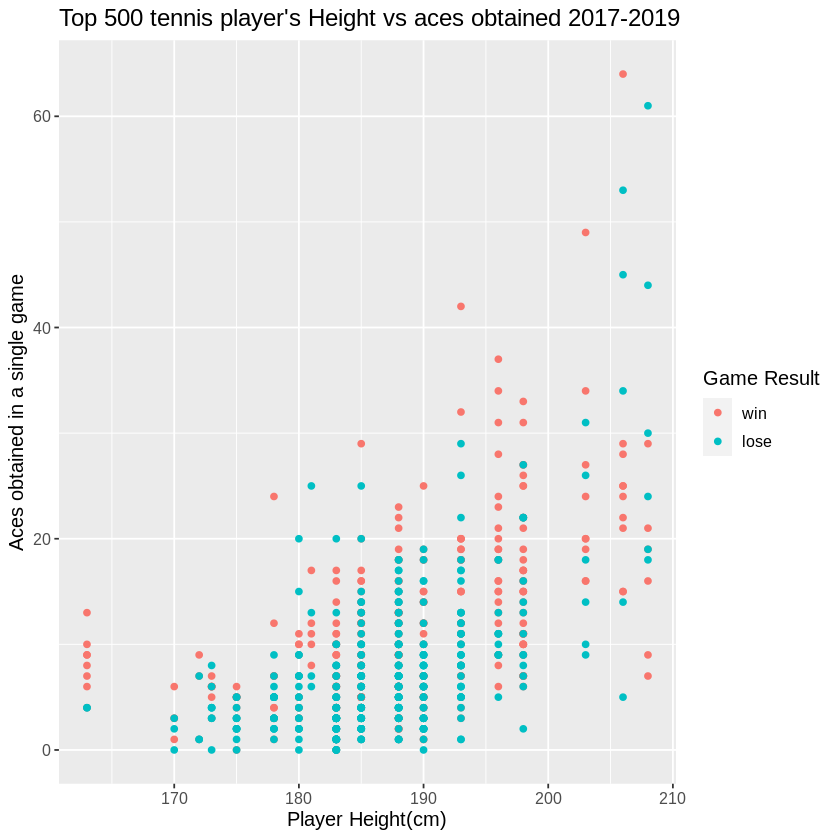

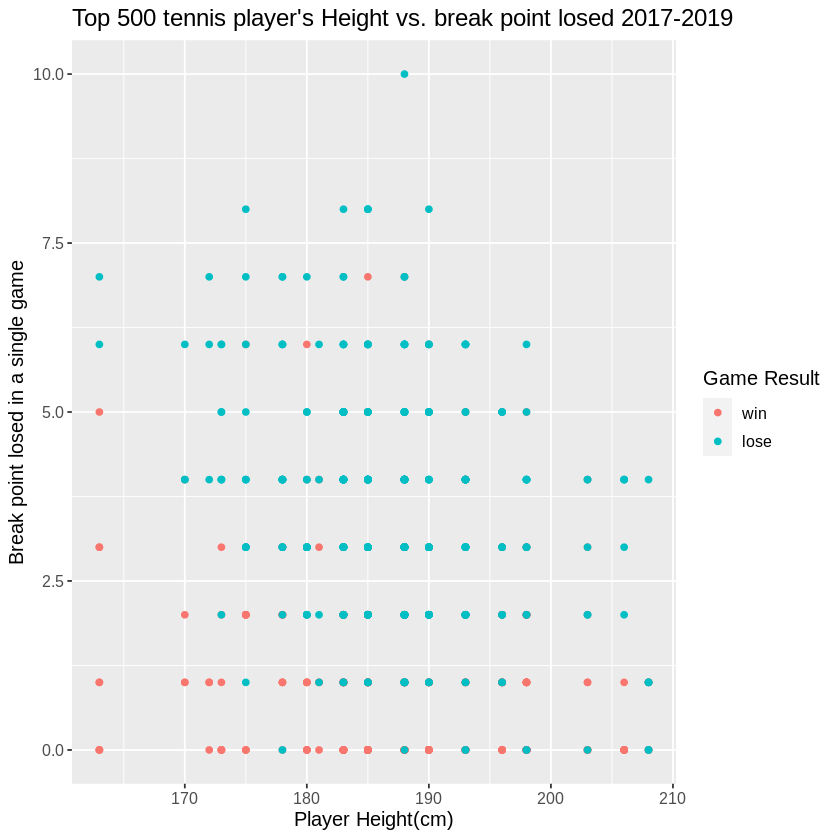

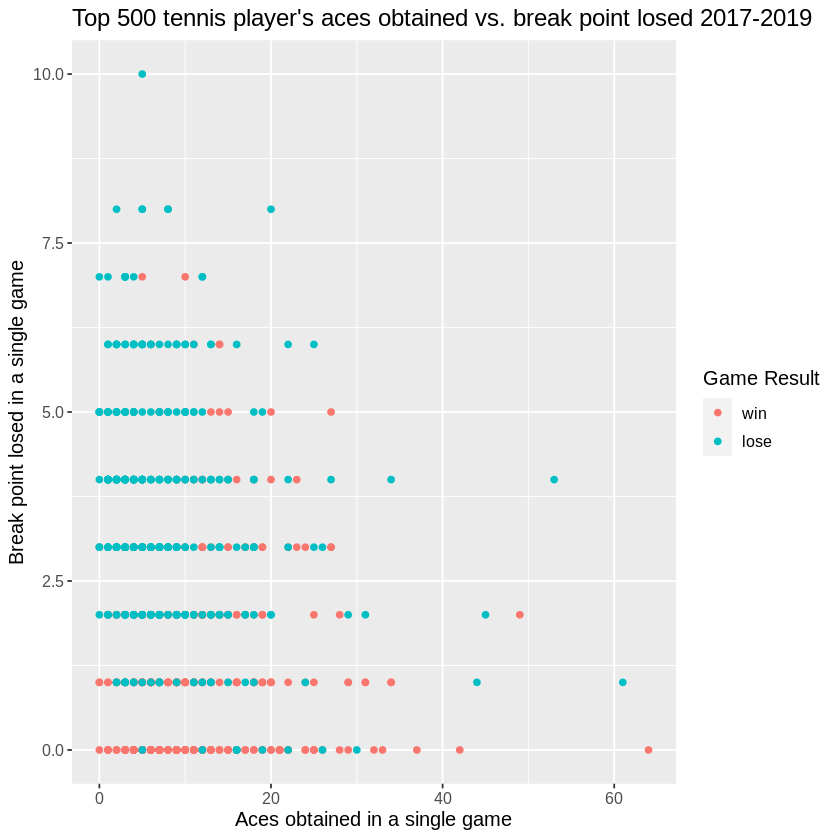

In [22]:
#Visualization of training data set
height_ace_plot<- tennis_train%>%
    ggplot(aes(x=height, y=ace, colour=result))+
    geom_point()+
    labs(x="Player Height(cm)", y="Aces obtained in a single game", colour="Game Result")+
    theme(text=element_text(size=12))+
    ggtitle("Top 500 tennis player's Height vs aces obtained 2017-2019")

height_ace_plot


height_bpLosed_plot<-tennis_train%>%
    ggplot(aes(x=height, y=bpLosed, colour=result))+
    geom_point()+
    labs(x="Player Height(cm)", y="Break point losed in a single game", colour="Game Result")+
    theme(text=element_text(size=12))+
    ggtitle("Top 500 tennis player's Height vs. break point losed 2017-2019")

height_bpLosed_plot


aces_bpLosed_plot<-tennis_train%>%
    ggplot(aes(x=ace, y=bpLosed, colour=result))+
    geom_point()+
    labs(x="Aces obtained in a single game", y="Break point losed in a single game", colour="Game Result")+
    theme(text=element_text(size=12))+
    ggtitle("Top 500 tennis player's aces obtained vs. break point losed 2017-2019")

aces_bpLosed_plot

## IV. Method

The variables selected are the height of the player, number of aces hit and number of breakpoints lost by the player in a single game. Breakpoint loss (bpLosed) is a new column created by subtracting the two given variables in the data set,  breakpoints faced (bpFaced)and breakpoints saved (bpSaved). 

The relationship between (1)height vs. aces hit, (2)height vs. breakpoint lost and (3)breakpoints lost vs. aces hit will be analyzed. From the summary data shown above, mean height for top 500 players is 187.3cm which is 11 cm taller than world's male's average height according to WHO. Variables chosen based on the assumption that tennis is a sport that favors players with a higher height.  Scatterplot created for the above three relationships will provide whether or not heights have an association of the aces obtained and breakpoint lost in game which have direct relationship to game result. Whether serving more aces and losing less breakpoints have an association with game results can be proven through the third graph. 

A KNN-classification model will be built using standardized data and the decision boundary will be presented on our scatterplot for our graph visualization. For all three graphs, the process of finding our decision boundary are the same. First, select the optimum k value by dividing training data set into 10 folds. Create a accuracy vs. K(neighbors) graph and select the optimum K with the highest accuracy value. Then build fitted KNN-classification model and test the accuracy of the model we built using test data set. Decision boundaries were then built to see if there is a golden standard of height that can acheive the most aces and bplosed.

## V.Results & Discussion

### Aces vs. Player height(cm)

#### 1. K value selection

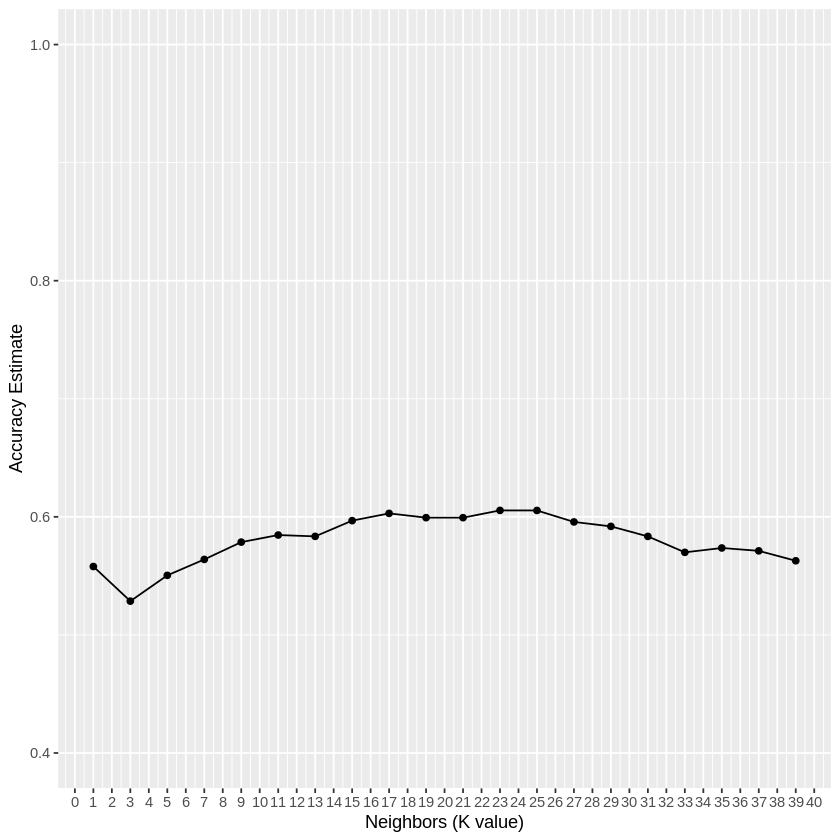

In [53]:
tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = result)

tennis_recipe<- recipe(result~height+ace, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors()) 

knn_tune<-nearest_neighbor(weight_func="rectangular", neighbor=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

knn_results <- workflow() %>%
  add_recipe(tennis_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = tennis_vfold, grid = k_vals) %>%
  collect_metrics() 

accuracies<- knn_results %>% 
       filter(.metric=="accuracy")

accuracy_versus_k<- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (K value)", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k
#accuracy is similar, chose smaller k since variation is smaller (improves the accuracy)

Figure 2.1 accuracy vs. k plot

 #### Result : The accuracy estimate graph is showing a flat 

#### 2. Build Fitted Classification Model

In [54]:
#Building fitted model
set.seed(3456)
tennis_model<-nearest_neighbor(weight_func="rectangular", neighbors=21)%>%
    set_engine("kknn")%>%
    set_mode("classification")
tennis_recipe<- recipe(result~height+ace, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors()) 
tennis_workflow<- workflow()%>%
    add_model(tennis_model)%>%
    add_recipe(tennis_recipe)

tennis_fit<-fit(tennis_workflow, data=tennis_train)


#### 3. Test Data Accuracy

In [55]:
#Pass the test dataset into fitted model
tennis_test_prediction<- predict(tennis_fit , tennis_test) %>%
    bind_cols(tennis_test)

#determine accuracy of predictions
tennis_prediction_accuracy<- tennis_test_prediction %>%
         metrics(truth = result, estimate = .pred_class)%>%
         filter(.metric=="accuracy")
tennis_prediction_accuracy
tennis_mat<- tennis_test_prediction %>% 
       conf_mat(truth = result, estimate = .pred_class)

tennis_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5367647


          Truth
Prediction win lose
      win  103   82
      lose  44   43

In [56]:
#Perform Cross Validation
tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = result)
tennis_resample_fit <- workflow() %>%
       add_recipe(tennis_recipe) %>%
       add_model(tennis_model) %>%
       fit_resamples(resamples = tennis_vfold)
tennis_metrics<-collect_metrics(tennis_resample_fit)
tennis_metrics
##high accuracy and low standard error

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.5993024,10,0.01585107
roc_auc,binary,0.5859757,10,0.01408446


#### 4. Create Decision Boundaries

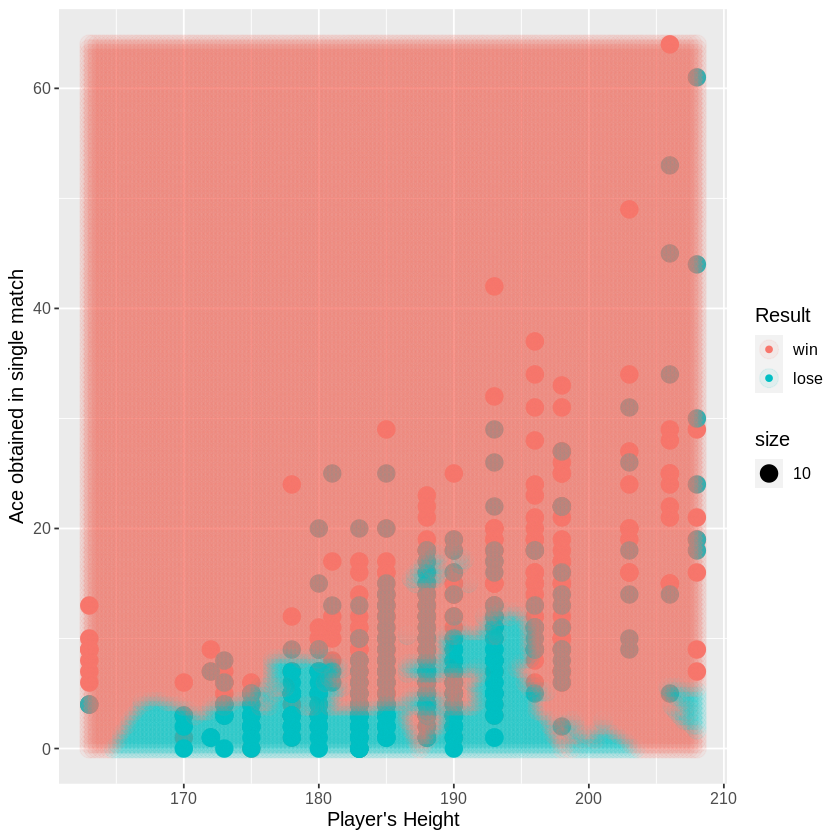

In [67]:
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(tennis_train$height), 
                max(tennis_train$height), 
                length.out = 150)
smo_grid <- seq(min(tennis_train$ace), 
                max(tennis_train$ace), 
                length.out = 150)
asgrid <- as_tibble(expand.grid(height = are_grid, 
                                ace = smo_grid))

# # use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(tennis_fit, asgrid)

# # bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

# # plot:
# # 1. the colored scatter of the original data
# # 2. the faded colored scatter for the grid points
wkflw_plot <-ggplot() +
  geom_point(data = tennis_train, 
             mapping = aes(x = height, 
                           y = ace, 
                           color = result, 
                           size = 10), 
             alpha = 2) +
  geom_point(data = prediction_table, 
             mapping = aes(x = height, 
                           y = ace, 
                           color = Class), 
             alpha = 0.08, 
             size = 5) +
  labs(color = "Result", 
       x = "Player's Height", 
       y = "Ace obtained in single match") +
  theme(text = element_text(size = 12))
wkflw_plot


Discussion: how i might improve the plot: the decision boundary model is built to fill the whole plot with color and since the upper left of our plot have no data points, the decision boundary plot does not provide a clear boundary on winners ace obtained. 

# Height vs. Break Point Losed

#### 1. K value selection

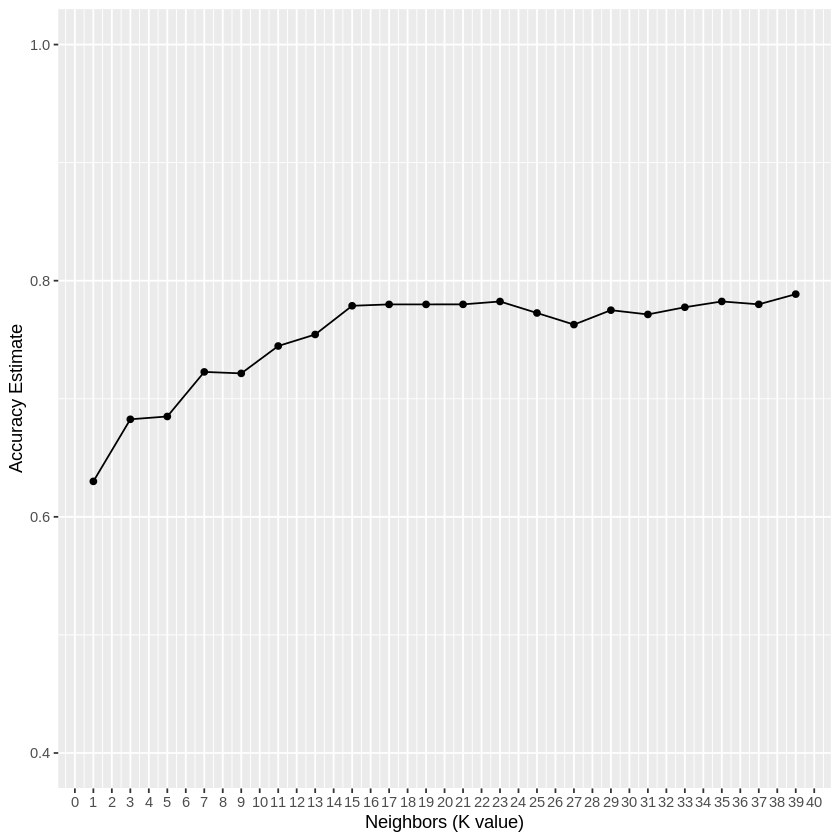

In [38]:
tennis_recipe1<- recipe(result~height+bpLosed, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors()) 

knn_tune<-nearest_neighbor(weight_func="rectangular", neighbor=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

knn_results <- workflow() %>%
  add_recipe(tennis_recipe1) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = tennis_vfold, grid = k_vals) %>%
  collect_metrics() 

accuracies<- knn_results %>% 
       filter(.metric=="accuracy")

accuracy_versus_k<- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (K value)", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k
#accuracy is similar, chose smaller k since variation is smaller (improves the accuracy)

#### 2. Build Fitted Classification Model

In [39]:
#Building fitted model
set.seed(3456)
tennis_model<-nearest_neighbor(weight_func="rectangular", neighbors=19)%>%
    set_engine("kknn")%>%
    set_mode("classification")
tennis_workflow1<- workflow()%>%
    add_model(tennis_model)%>%
    add_recipe(tennis_recipe1)

tennis_fit1<-fit(tennis_workflow1, data=tennis_train)

#### 3. Test Accuracy

In [41]:
#Pass the test dataset into fitted model
tennis_test_prediction1<- predict(tennis_fit1 , tennis_test) %>%
    bind_cols(tennis_test)

#determine accuracy of predictions
tennis_prediction_accuracy<- tennis_test_prediction1 %>%
         metrics(truth = result, estimate = .pred_class)%>%
         filter(.metric=="accuracy")
tennis_prediction_accuracy

tennis_mat<- tennis_test_prediction1 %>% 
       conf_mat(truth = result, estimate = .pred_class)

tennis_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7977941


          Truth
Prediction win lose
      win  125   33
      lose  22   92

In [42]:
#Perform Cross Validation
tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = result)
tennis_resample_fit1 <- workflow() %>%
       add_recipe(tennis_recipe1) %>%
       add_model(tennis_model) %>%
       fit_resamples(resamples = tennis_vfold)
tennis_metrics<-collect_metrics(tennis_resample_fit1)
tennis_metrics
##high accuracy and low standard error

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.7742473,10,0.009671935
roc_auc,binary,0.8344138,10,0.010699420


#### 4. Create Decision Boundaries

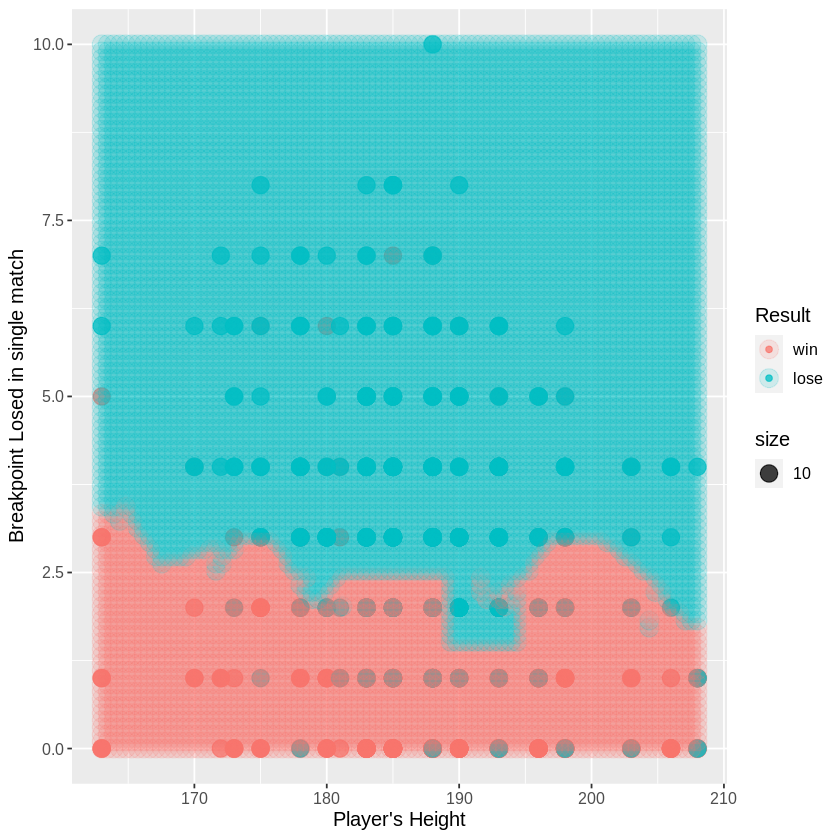

In [69]:
set.seed(3456)
# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(tennis_train$height), 
                max(tennis_train$height), 
                length.out = 100)
smo_grid <- seq(min(tennis_train$bpLosed), 
                max(tennis_train$bpLosed), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(height = are_grid, 
                               bpLosed = smo_grid))

# # use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(tennis_fit1, asgrid)

# # bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

# # plot:
# # 1. the colored scatter of the original data
# # 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = tennis_train, 
             mapping = aes(x = height, 
                           y = bpLosed, 
                           color = result, 
                           size = 10), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = height, 
                           y = bpLosed, 
                           color = Class), 
             alpha = 0.15, 
             size = 5) +
  labs(color = "Result", 
       x = "Player's Height", 
       y = "Breakpoint Losed in single match") +
  theme(text = element_text(size = 12))

wkflw_plot

# Ace vs. Breakpoint Losed

#### 1. K value selection

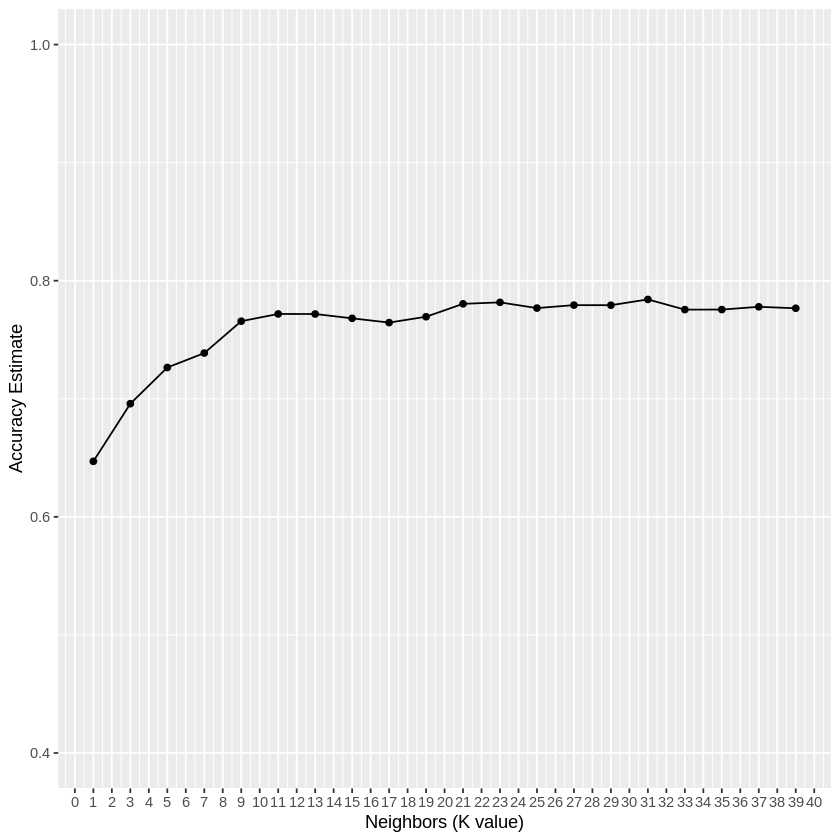

In [43]:
tennis_recipe2<- recipe(result~ace+bpLosed, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors()) 

knn_tune<-nearest_neighbor(weight_func="rectangular", neighbor=tune())%>%
    set_engine("kknn")%>%
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 2))

knn_results <- workflow() %>%
  add_recipe(tennis_recipe2) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = tennis_vfold, grid = k_vals) %>%
  collect_metrics() 

accuracies<- knn_results %>% 
       filter(.metric=="accuracy")

accuracy_versus_k<- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors (K value)", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 50, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k
#accuracy is similar, chose smaller k since variation is smaller (improves the accuracy)

#### 2. Build Fitted Classification Model

In [44]:
#Building fitted model
set.seed(3456)
tennis_model<-nearest_neighbor(weight_func="rectangular", neighbors=11)%>%
    set_engine("kknn")%>%
    set_mode("classification")
tennis_workflow2<- workflow()%>%
    add_model(tennis_model)%>%
    add_recipe(tennis_recipe2)

tennis_fit2<-fit(tennis_workflow2, data=tennis_train)

#### 3. Test Accuracy

In [45]:
#Pass the test dataset into fitted model
tennis_test_prediction2<- predict(tennis_fit2 , tennis_test) %>%
    bind_cols(tennis_test)
tennis_test_prediction2
#determine accuracy of predictions
tennis_prediction_accuracy<- tennis_test_prediction2 %>%
         metrics(truth = result, estimate = .pred_class)  
tennis_mat<- tennis_test_prediction2 %>% 
       conf_mat(truth = result, estimate = .pred_class)

tennis_mat

.pred_class,height,ace,bpLosed,result
<fct>,<dbl>,<dbl>,<dbl>,<fct>
lose,183,3,3,win
win,185,6,0,win
win,163,5,0,win
⋮,⋮,⋮,⋮,⋮
lose,198,5,5,lose
lose,190,10,4,lose
win,183,2,2,lose


          Truth
Prediction win lose
      win  121   39
      lose  26   86

In [46]:
#Perform Cross Validation
tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = result)
tennis_resample_fit2 <- workflow() %>%
       add_recipe(tennis_recipe2) %>%
       add_model(tennis_model) %>%
       fit_resamples(resamples = tennis_vfold)
tennis_metrics<-collect_metrics(tennis_resample_fit2)
tennis_metrics
##high accuracy and low standard error

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.7718384,10,0.01006476
roc_auc,binary,0.8372919,10,0.01376102


#### 4. Create Decision Boundaries

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~11, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2112332
Best kernel: rectangular
Best k: 11

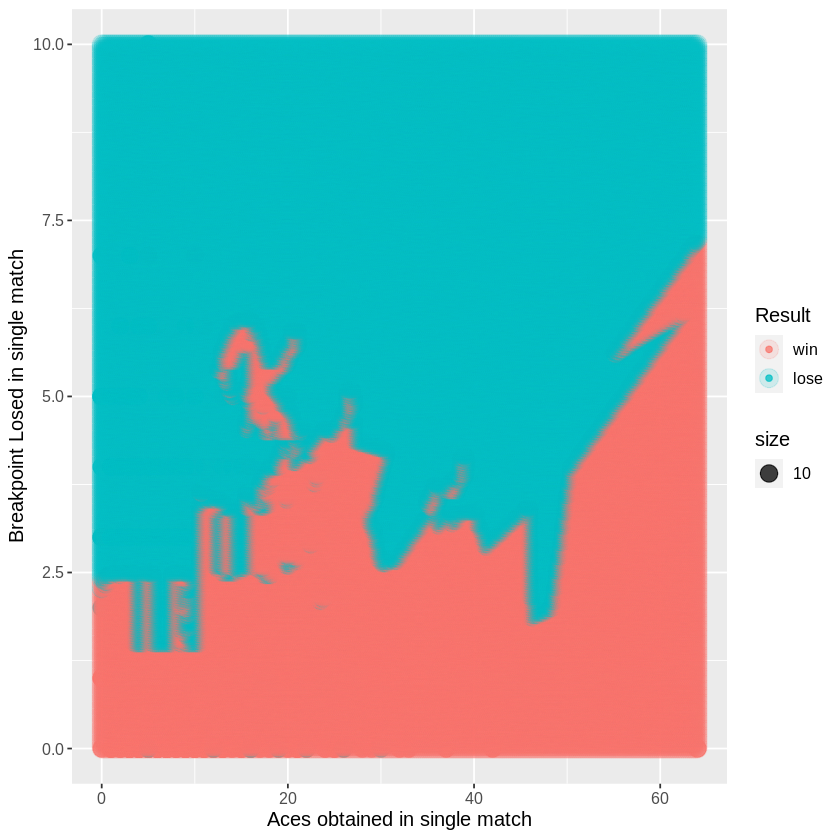

In [47]:
set.seed(3456)
tennis_recipe2<- recipe(result~ace+bpLosed, data=tennis_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())
tennis_model<-nearest_neighbor(weight_func="rectangular", neighbors=11)%>%
    set_engine("kknn")%>%
    set_mode("classification")
tennis_workflow2<- workflow()%>%
    add_model(tennis_model)%>%
    add_recipe(tennis_recipe2)

tennis_fit<-fit(tennis_workflow2, data=tennis_train)
tennis_fit

# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(tennis_train$ace), 
                max(tennis_train$ace), 
                length.out = 300)
smo_grid <- seq(min(tennis_train$bpLosed), 
                max(tennis_train$bpLosed), 
                length.out = 300)
asgrid <- as_tibble(expand.grid(ace = are_grid, 
                               bpLosed = smo_grid))

# # use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(tennis_fit, asgrid)

# # bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

# # plot:
# # 1. the colored scatter of the original data
# # 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = tennis_train, 
             mapping = aes(x = ace, 
                           y = bpLosed, 
                           color = result, 
                           size = 10), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = ace, 
                           y = bpLosed, 
                           color = Class), 
             alpha = 0.15, 
             size = 5) +
  labs(color = "Result", 
       x = "Aces obtained in single match", 
       y = "Breakpoint Losed in single match") +
  theme(text = element_text(size = 12))

wkflw_plot

# Expected outcomes and significance #

After our decision boundary is created, finding out what is the minimum amount of aces a player is required to obtain and/or maximum number of breakpoints a player can lose per game, for players with different height to get a winning game result,  is our expected outcome.  

The purpose of our project  is to aid the coach to set training goals for their players with different heights. If  biological differences have a significant impact on game results, additional training is needed. The ability to quantify what’s the target number to reach increase confidence in tennis players which is what we intend to achieve.   

Future studies can be linking the tennis player’s training menu and the effect on increasing aces obtained/ breakpoints lost in a game to our target ace/ breakpoint lost goals.


The three graphs that we choose from the data set are -> 
 (1)height vs. aces hit
 (2)height vs. breakpoint lost
 (3)breakpoints lost vs. aces 
We hope to analyse each of the following graphs and develop an outcome that will help the players and coaches formulate a strategy for the upcoming matches. As we see in the first graph (height vs. aces hit) we tend to see as the height of the players increases they tend to win more matches, and after a particular increase in height, they tend to lose more matches than win because the increase in height after a point affects the other aspects of the game such as forehand and backhand and according to this graph the players between 180 to 200 cm have won most of the matches thus the best height of a tennis player should be between 180 to 200 cm. This is true as the three best tennis players Roger Federer, Novak Djokovic and Rafael Nadal in the world, who have dominated the sport for the last 15 years have all been between 180 to 200 cm. 
The second graph Height vs Breakpoints lost shows us that as the height of the player of the increases they tend to loose less breakpoints. This data helps the player prepare for their opponent as this tells us the player with more height loose less breakpoints in a match as compared to shorter players so this will help the coaches and players prepare for the opponent because they would know what kind of a server they would be facing in the match and how the other player can handle the pressure during a breakpoint in the match as this also speaks to the mental strength of the player. 
The third graph breakpoints lost vs. aces shows us that as the number of aces obtained increases, the number of breakpoints lost in a single match decreases, so this tells us the better the server in the matchless the breakpoint he loses.
All these graphs help the coaches and players to understand the game better and help them prepare for their respective matches. This data is also useful for the commentators to refer to get their facts right. Any tennis enthusiast can go through this data to predict matches to guess who will win. This is also helpful for the people who indulge in sports betting.